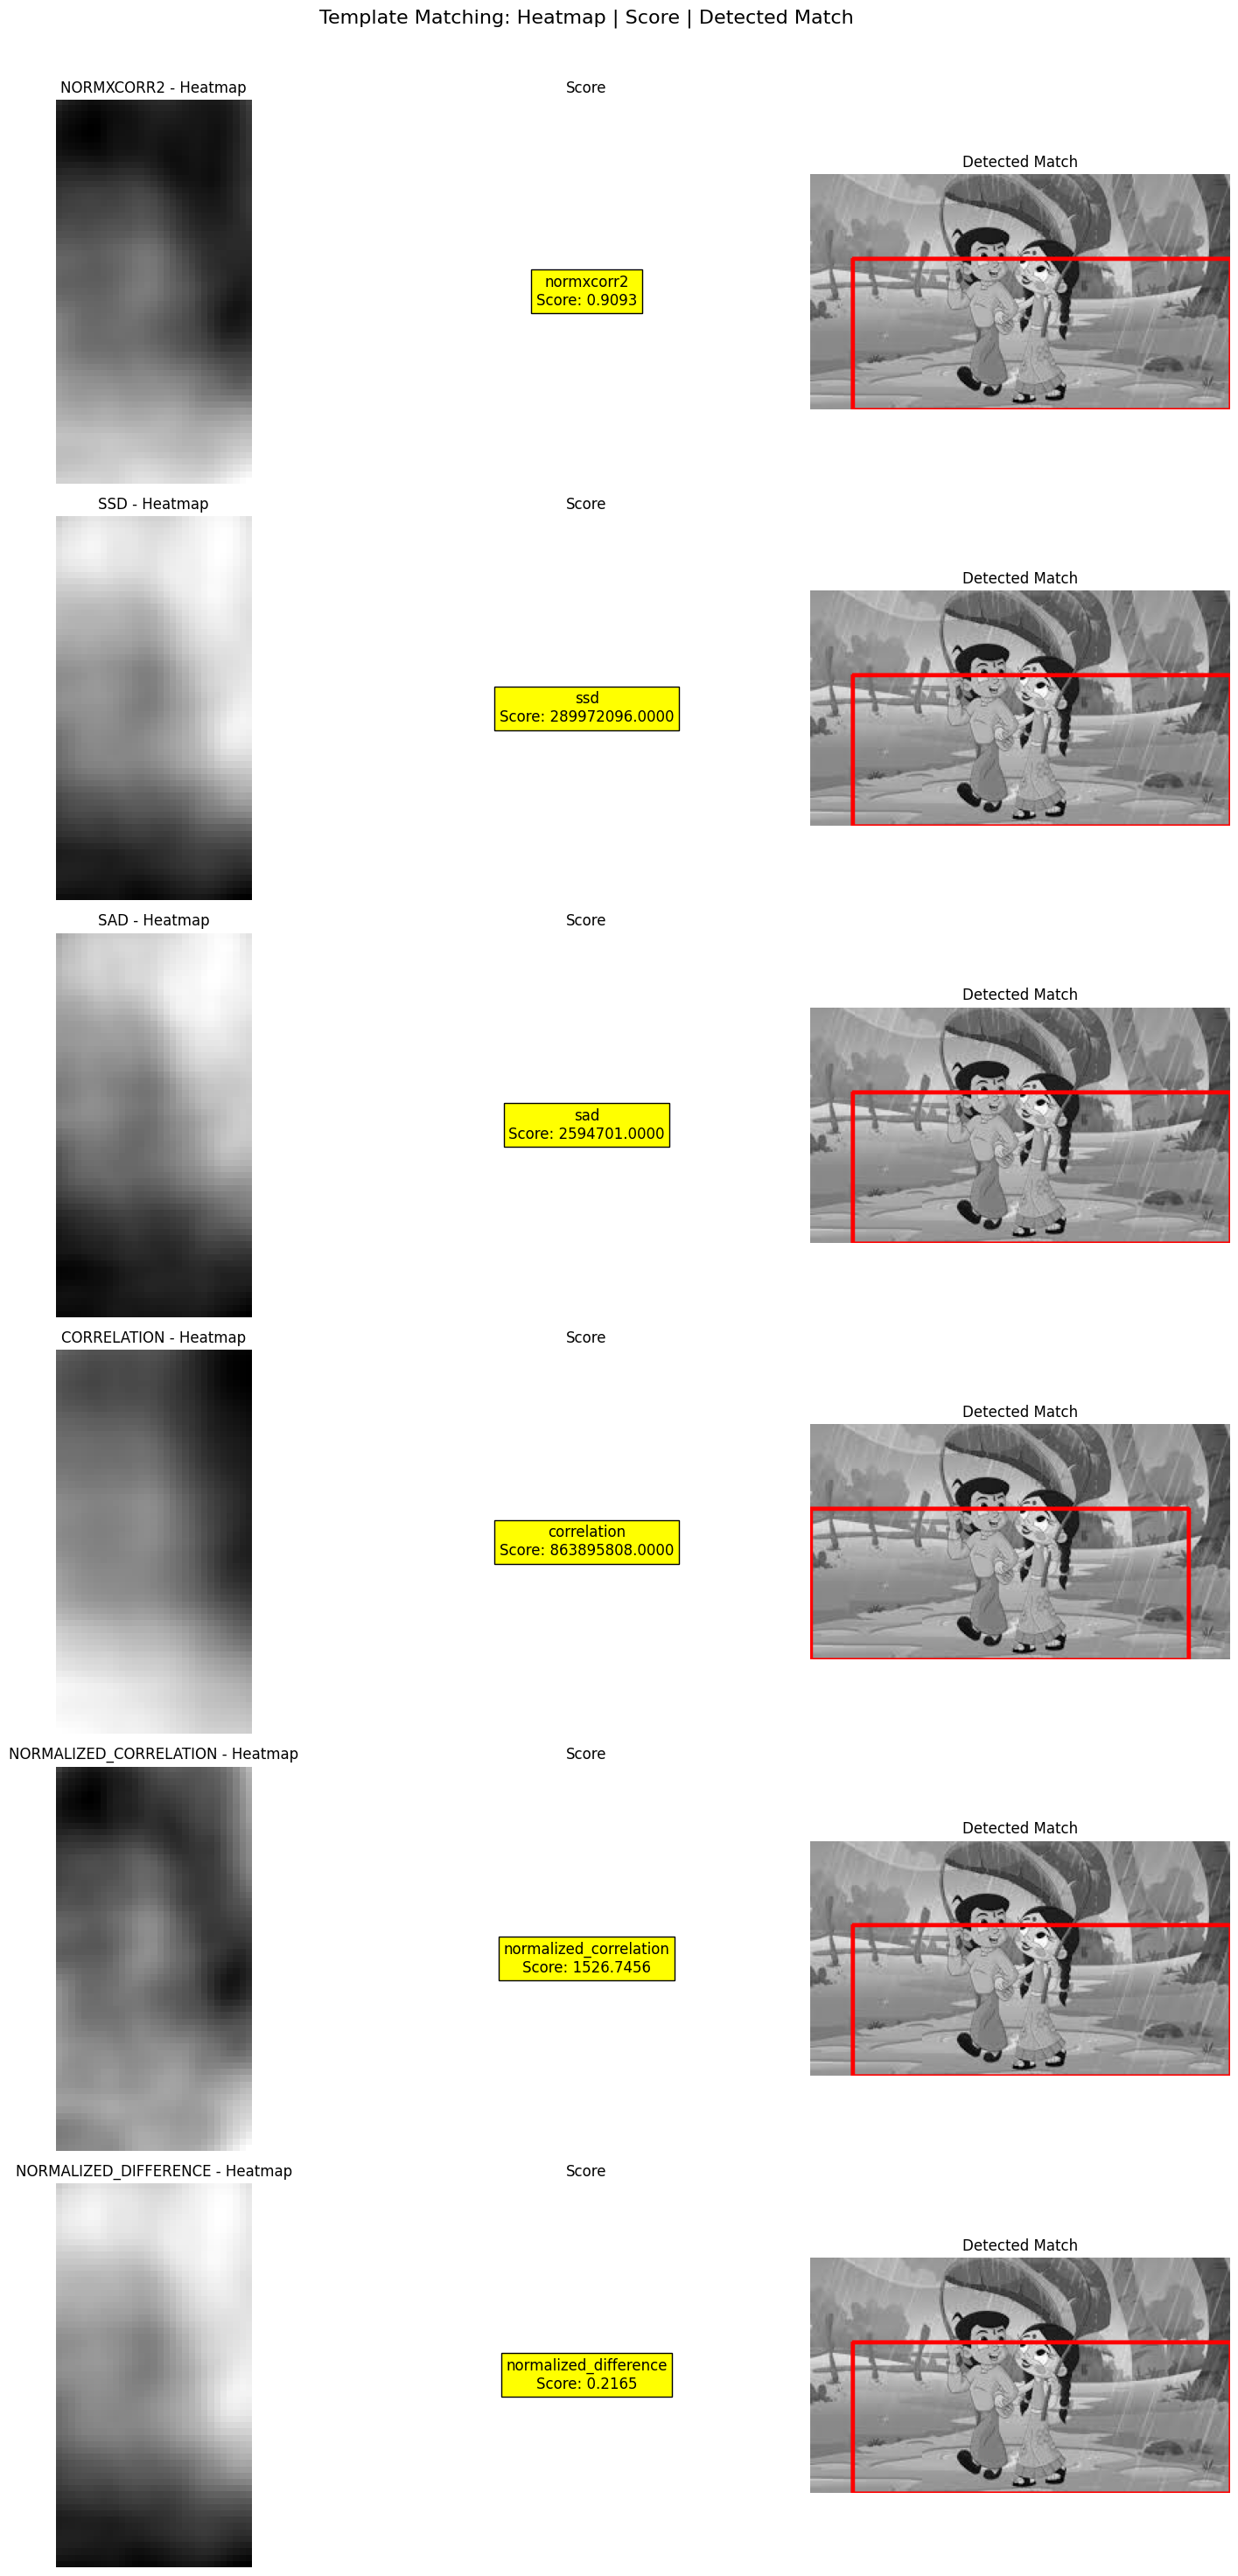

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Load and Preprocess Images ---
img = cv2.imread(r"/content/download (5).jpeg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread(r"/content/images (4).jpeg", cv2.IMREAD_GRAYSCALE)

# Resize template if it's larger
if template.shape[0] > img.shape[0] or template.shape[1] > img.shape[1]:
    scale = min(img.shape[0] / template.shape[0], img.shape[1] / template.shape[1]) * 0.9
    template = cv2.resize(template, (0, 0), fx=scale, fy=scale)

h, w = template.shape
methods = ['normxcorr2', 'ssd', 'sad', 'correlation', 'normalized_correlation', 'normalized_difference']

# Create figure
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 30))
fig.suptitle("Template Matching: Heatmap | Score | Detected Match", fontsize=16)

# Convert template to float for math
template_d = template.astype(np.float32)

for i, method in enumerate(methods):
    result = None
    score = None
    top_left = (0, 0)
    img_copy = img.copy()

    if method == 'normxcorr2':
        result = cv2.matchTemplate(img.astype(np.float32), template_d, cv2.TM_CCORR_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        top_left = max_loc
        score = max_val

    else:
        img_h, img_w = img.shape
        res_h = img_h - h + 1
        res_w = img_w - w + 1
        result = np.zeros((res_h, res_w), dtype=np.float32)

        for y in range(res_h):
            for x in range(res_w):
                patch = img[y:y+h, x:x+w].astype(np.float32)
                if method == 'ssd':
                    diff = patch - template_d
                    result[y, x] = np.sum(diff ** 2)
                elif method == 'sad':
                    diff = np.abs(patch - template_d)
                    result[y, x] = np.sum(diff)
                elif method == 'correlation':
                    result[y, x] = np.sum(patch * template_d)
                elif method == 'normalized_correlation':
                    patch_norm = (patch - np.mean(patch)) / (np.std(patch) + 1e-6)
                    temp_norm = (template_d - np.mean(template_d)) / (np.std(template_d) + 1e-6)
                    result[y, x] = np.sum(patch_norm * temp_norm)
                elif method == 'normalized_difference':
                    diff = patch - template_d
                    result[y, x] = np.sum(diff ** 2) / (np.sum(template_d ** 2) + 1e-6)

        if method in ['ssd', 'sad', 'normalized_difference']:
            min_val = np.min(result)
            score = min_val
            top_left = np.unravel_index(np.argmin(result), result.shape)[::-1]
        else:
            max_val = np.max(result)
            score = max_val
            top_left = np.unravel_index(np.argmax(result), result.shape)[::-1]

    # -- Plotting --
    row = i

    # 1. Heatmap
    ax1 = axes[row, 0]
    ax1.imshow(result, cmap='gray')
    ax1.set_title(f'{method.upper()} - Heatmap')
    ax1.axis('off')

    # 2. Score Text
    ax2 = axes[row, 1]
    ax2.text(0.5, 0.5, f'{method}\nScore: {score:.4f}', ha='center', va='center',
             fontsize=12, bbox=dict(facecolor='yellow', edgecolor='black'))
    ax2.set_title("Score")
    ax2.axis('off')

    # 3. Detected Match
    ax3 = axes[row, 2]
    match_img = cv2.cvtColor(img_copy.copy(), cv2.COLOR_GRAY2RGB)
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(match_img, top_left, bottom_right, (255, 0, 0), 2)
    ax3.imshow(match_img)
    ax3.set_title("Detected Match")
    ax3.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("template_matching_all_methods.png")
plt.show()
